In [30]:
from nilearn import datasets
from nilearn import input_data
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import numpy as np
from sklearn.covariance import GraphicalLassoCV
from matplotlib.pyplot import cm


In [8]:
dataset = datasets.fetch_development_fmri(n_subjects=10)

In [3]:
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
    'Posterior Cingulate Cortex',
    'Left Temporoparietal junction',
    'Right Temporoparietal junction',
    'Medial prefrontal cortex',
    ]

In [9]:
masker = input_data.NiftiSpheresMasker(
    dmn_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=2)

# Additionally, we pass confound information to ensure our extracted
# signal is cleaned from confounds.

func_filename = dataset.func[0]
confounds_filename = dataset.confounds[0]

time_series = masker.fit_transform(func_filename,
                                   confounds=[confounds_filename])

________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(('C:\\Users\\Bokkin '
 'Wang/nilearn_data\\development_fmri\\development_fmri\\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'), 
{ 'allow_overlap': False,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'high_variance_confounds': False,
  'low_pass': 0.1,
  'mask_img': None,
  'radius': 8,
  'seeds': [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)],
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  't_r': 2}, confounds=[ 'C:\\Users\\Bokkin '
  'Wang/nilearn_data\\development_fmri\\development_fmri\\sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv'], sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache\joblib), memory_level=1, verbose=2)
[NiftiSpheresMasker.transform_single_imgs] Loading data from C:\Users\Bokki

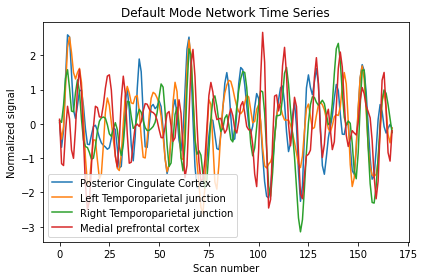

In [10]:
for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)

plt.title('Default Mode Network Time Series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.legend()
plt.tight_layout()

In [14]:
connectivity_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrix = connectivity_measure.fit_transform(
    [time_series])[0]

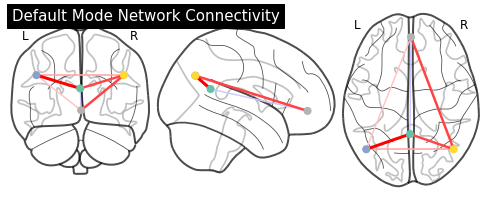

In [15]:
plotting.plot_connectome(partial_correlation_matrix, dmn_coords,
                         title="Default Mode Network Connectivity")

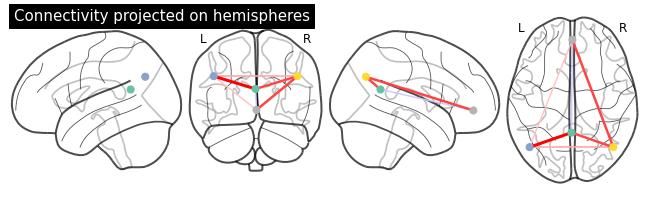

In [16]:
plotting.plot_connectome(partial_correlation_matrix, dmn_coords,
                         title="Connectivity projected on hemispheres",
                         display_mode='lyrz')

In [18]:
view = plotting.view_connectome(partial_correlation_matrix, dmn_coords)
view

In [21]:
power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
print('Stacked power coordinates in array of shape {0}.'.format(coords.shape))

Stacked power coordinates in array of shape (264, 3).


In [22]:
spheres_masker = input_data.NiftiSpheresMasker(
    seeds=coords, smoothing_fwhm=6, radius=5.,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2)

timeseries = spheres_masker.fit_transform(func_filename,
                                          confounds=confounds_filename)

In [26]:
covariance_estimator = GraphicalLassoCV(cv=3, verbose=1)
covariance_estimator.fit(timeseries)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  1 out of 4:   3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  2 out of 4:  12s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  3 out of 4:  26s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.7s finished


[GraphicalLassoCV] Done refinement  4 out of 4:  40s


D:\anaconda\envs\mne\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=3, verbose=1)

In [27]:
matrix = covariance_estimator.covariance_
print('Covariance matrix has shape {0}.'.format(matrix.shape))

Covariance matrix has shape (264, 264).


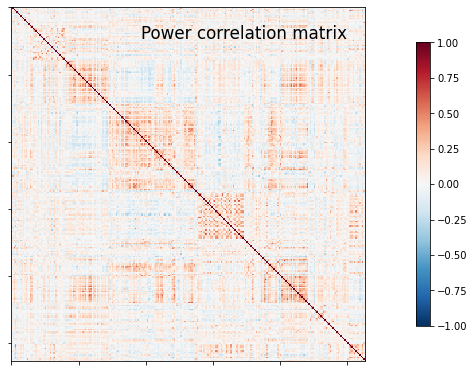

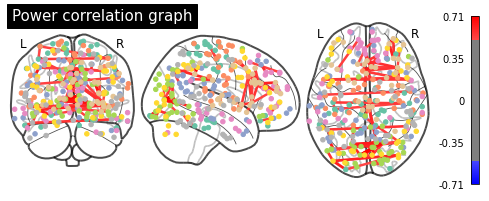

In [28]:
plotting.plot_matrix(matrix, vmin=-1., vmax=1., colorbar=True,
                     title='Power correlation matrix')

# Tweak edge_threshold to keep only the strongest connections.
plotting.plot_connectome(matrix, coords, title='Power correlation graph',
                         edge_threshold='99.8%', node_size=20, colorbar=True)

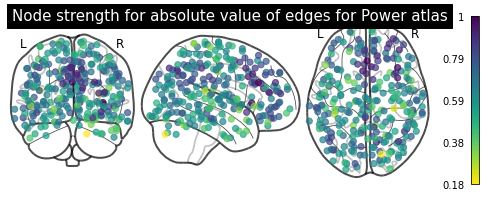

In [29]:
node_strength = np.sum(np.abs(matrix), axis=0)
node_strength /= np.max(node_strength)

plotting.plot_markers(
    node_strength,
    coords,
    title='Node strength for absolute value of edges for Power atlas',
)

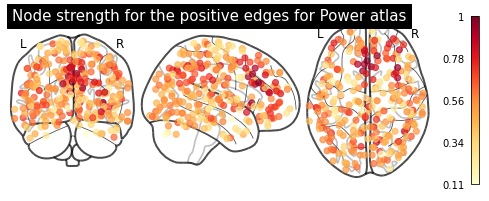

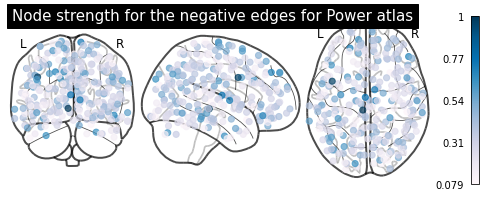

In [31]:
# clip connectivity matrix to preserve positive and negative edges
positive_edges = np.clip(matrix, 0, matrix.max())
negative_edges = np.clip(matrix, matrix.min(), 0)

# calculate strength for positive edges
node_strength_positive = np.sum(np.abs(positive_edges), axis=0)
node_strength_positive /= np.max(node_strength_positive)

# calculate strength for negative edges
node_strength_negative = np.sum(np.abs(negative_edges), axis=0)
node_strength_negative /= np.max(node_strength_negative)

# plot nodes' strength for positive edges
plotting.plot_markers(
    node_strength_positive,
    coords,
    title='Node strength for the positive edges for Power atlas',
    node_cmap=cm.YlOrRd
)

# plot nodes' strength for negative edges
plotting.plot_markers(
    node_strength_negative,
    coords,
    title='Node strength for the negative edges for Power atlas',
    node_cmap=cm.PuBu
)

D:\anaconda\envs\mne\lib\site-packages\numpy\lib\npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
D:\anaconda\envs\mne\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


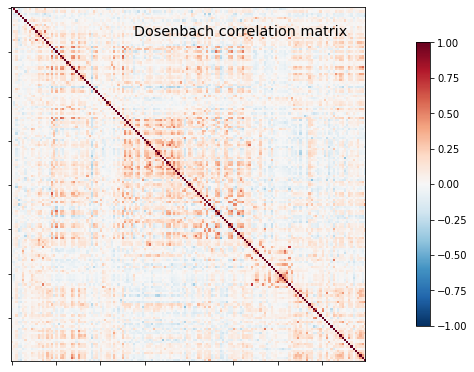

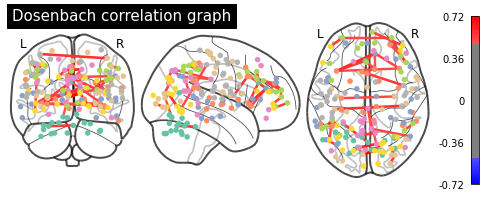

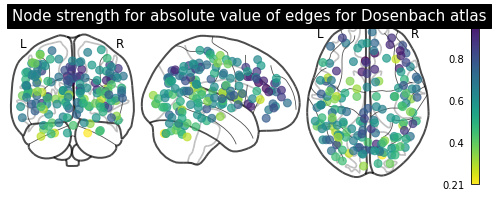

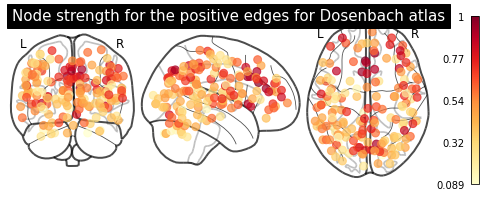

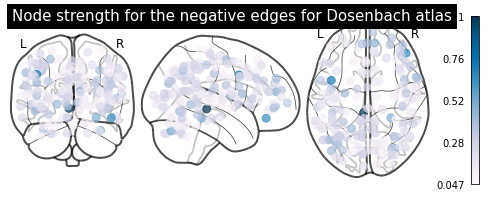

In [32]:
dosenbach = datasets.fetch_coords_dosenbach_2010()

coords = np.vstack((
    dosenbach.rois['x'],
    dosenbach.rois['y'],
    dosenbach.rois['z'],
)).T

spheres_masker = input_data.NiftiSpheresMasker(
    seeds=coords, smoothing_fwhm=6, radius=4.5,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2)

timeseries = spheres_masker.fit_transform(func_filename,
                                          confounds=confounds_filename)

covariance_estimator = GraphicalLassoCV()
covariance_estimator.fit(timeseries)
matrix = covariance_estimator.covariance_

plotting.plot_matrix(matrix, vmin=-1., vmax=1., colorbar=True,
                     title='Dosenbach correlation matrix')

plotting.plot_connectome(matrix, coords, title='Dosenbach correlation graph',
                         edge_threshold="99.7%", node_size=20, colorbar=True)


# calculate average strength for each node
node_strength = np.sum(np.abs(matrix), axis=0)
node_strength /= np.max(node_strength)

plotting.plot_markers(
    node_strength,
    coords,
    title='Node strength for absolute value of edges for Dosenbach atlas',
)

# clip connectivity matrix to preserve positive and negative edges
positive_edges = np.clip(matrix, 0, matrix.max())
negative_edges = np.clip(matrix, matrix.min(), 0)

# calculate strength for positive and edges
node_strength_positive = np.sum(np.abs(positive_edges), axis=0)
node_strength_positive /= np.max(node_strength_positive)
node_strength_negative = np.sum(np.abs(negative_edges), axis=0)
node_strength_negative /= np.max(node_strength_negative)

# plot nodes' strength for positive edges
plotting.plot_markers(
    node_strength_positive,
    coords,
    title='Node strength for the positive edges for Dosenbach atlas',
    node_cmap=cm.YlOrRd
)

# plot nodes' strength for negative edges
plotting.plot_markers(
    node_strength_negative,
    coords,
    title='Node strength for the negative edges for Dosenbach atlas',
    node_cmap=cm.PuBu
)


In [34]:
print('Dosenbach networks names are {0}'.format(np.unique(dosenbach.networks)))

Dosenbach networks names are [b'cerebellum' b'cingulo-opercular' b'default' b'fronto-parietal'
 b'occipital' b'sensorimotor']
